# iSLAT Plotting Module — Standalone Plot Classes

This notebook demonstrates iSLAT's **new class-based plotting module**, which lets you create publication-quality plots **outside of the GUI** — in Jupyter notebooks or standalone scripts.

All plot classes inherit from `BasePlot` and share a common API:
- `generate_plot()` — build or refresh the plot
- `show()` — display interactively
- `save(path)` — export to PNG / PDF / SVG
- `close()` — free figure memory

## What This Notebook Covers:
1. **Setup** — Imports, molecule creation, and example data
2. **LineInspectionPlot** — Zoom into a narrow wavelength region with molecule model overlays
3. **PopulationDiagramPlot** — Boltzmann / rotation diagram from computed intensities
4. **FullSpectrumPlot** — Multi-panel overview of the full wavelength range
5. **MainPlotGrid** — Three-panel composite (spectrum + inspection + population diagram)
6. **Theming & Customisation** — Dark themes, custom colours, and saving figures
7. **BasePlot Utility Methods** — Molecule helpers available to all plot classes

In [1]:
# First, add the iSLAT package to the Python path
import sys
from pathlib import Path

# Navigate from notebook location to the iSLATTests directory (where iSLAT package lives)
notebook_dir = Path.cwd()
islat_root = notebook_dir.parent.parent  # Notebooks -> Examples -> iSLATTests
if str(islat_root) not in sys.path:
    sys.path.insert(0, str(islat_root))

# Core libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

# iSLAT data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeDict

# iSLAT standalone plot classes
from iSLAT.Modules.Plotting import (
    BasePlot,
    DEFAULT_THEME,
    LineInspectionPlot,
    PopulationDiagramPlot,
    FullSpectrumPlot,
    MainPlotGrid,
)

print("Imports successful!")
print(f"Available plot classes: LineInspectionPlot, PopulationDiagramPlot, FullSpectrumPlot, MainPlotGrid")

Imports successful!
Available plot classes: LineInspectionPlot, PopulationDiagramPlot, FullSpectrumPlot, MainPlotGrid


In [2]:
# --- Load observed data and create molecules ---
import pandas as pd

# Load CI Tau MIRI spectrum (Banzatti+2023b)
data_path = Path(islat_root) / "iSLAT" / "DATAFILES" / "EXAMPLE-data" / "CITau_MIRI_Banzatti+2023b.csv"
obs = pd.read_csv(data_path)

wave_grid     = obs["wave"].values
observed_flux = obs["flux"].values
observed_err  = obs["err"].values
continuum     = obs["cont"].values

print(f"Loaded: {data_path.name}")
print(f"  {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

# Paths to HITRAN parameter files
data_dir = Path(islat_root) / "iSLAT" / "DATAFILES" / "HITRANdata"
water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")

# Build a MoleculeDict with three molecules
wavelength_range = (float(wave_grid.min()), float(wave_grid.max()))

mol_dict = MoleculeDict(
    global_distance=160,
    global_stellar_rv=0.0,
    global_wavelength_range=wavelength_range,
    global_model_pixel_res=0.0013,
)

molecules_to_create = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "radius": 0.5, "color": "#0000FF",
             "displaylabel": "$H_2O$", "File Path": water_par_file},
    "CO":  {"Molecule Name": "CO",  "temp": 1000, "n_mol": 1e18, "radius": 0.4, "color": "#FF0000",
             "displaylabel": "CO",  "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 300,  "n_mol": 1e17, "radius": 0.5, "color": "green",
             "displaylabel": "$CO_2$", "File Path": co2_par_file},
}

mol_dict.load_molecules(
    molecules_data=[v for v in molecules_to_create.values()],
    initial_molecule_parameters=molecules_to_create,
)

# Set all FWHM values to 130, and all broadings to 1
mol_dict.bulk_update_parameters({"fwhm": 130, "broad": 1})

print(f"MoleculeDict: {list(mol_dict.keys())}")
print(f"Observed data: {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

Loaded: CITau_MIRI_Banzatti+2023b.csv
  10672 points, 4.90–28.72 μm
Deferring intensity calculations for 3 molecules
MoleculeDict: ['H2O', 'CO', 'CO2']
Observed data: 10672 points, 4.90–28.72 μm


## 1. LineInspectionPlot — Zoomed Wavelength Region

`LineInspectionPlot` shows a narrow wavelength window with the observed spectrum and overlaid molecule model(s). Useful for inspecting individual spectral lines.

**Key parameters:**
- `wave_data`, `flux_data` — full observed arrays
- `xmin`, `xmax` — wavelength bounds for the zoom region
- `molecule` — single molecule to overlay (or `molecules` for all visible)
- `line_data` — optional list of `(MoleculeLine, intensity, tau)` tuples for line markers
- `theme` — colour theme dictionary (defaults to light theme)

Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0


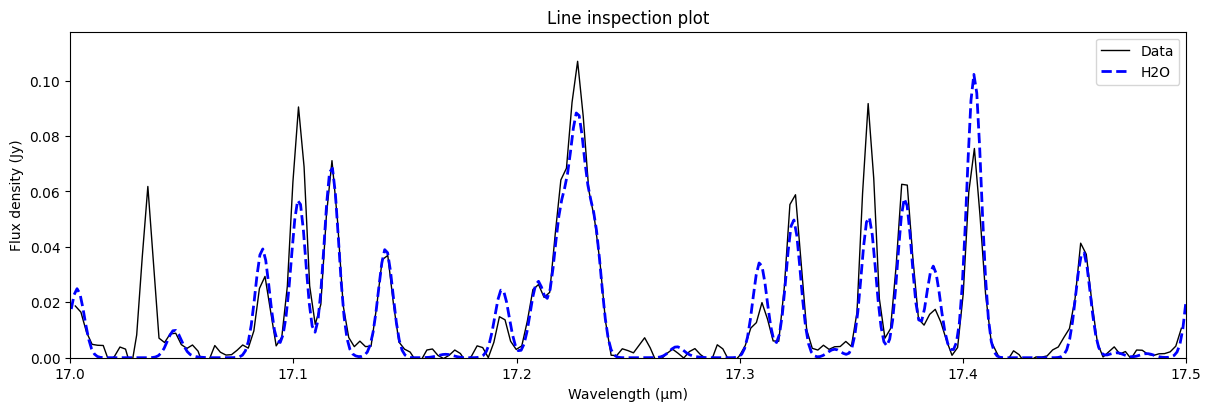

In [3]:
# --- Basic LineInspectionPlot with a single molecule ---

lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=17.0,
    xmax=17.5,
    molecule=mol_dict["H2O"],
    figsize=(12, 4),
)
lip.generate_plot()
lip.show()

Calculating intensity for CO2: T=300.0K, N_mol=1.00e+17, dv=1.0
Calculating intensity for CO: T=1000.0K, N_mol=1.00e+18, dv=1.0


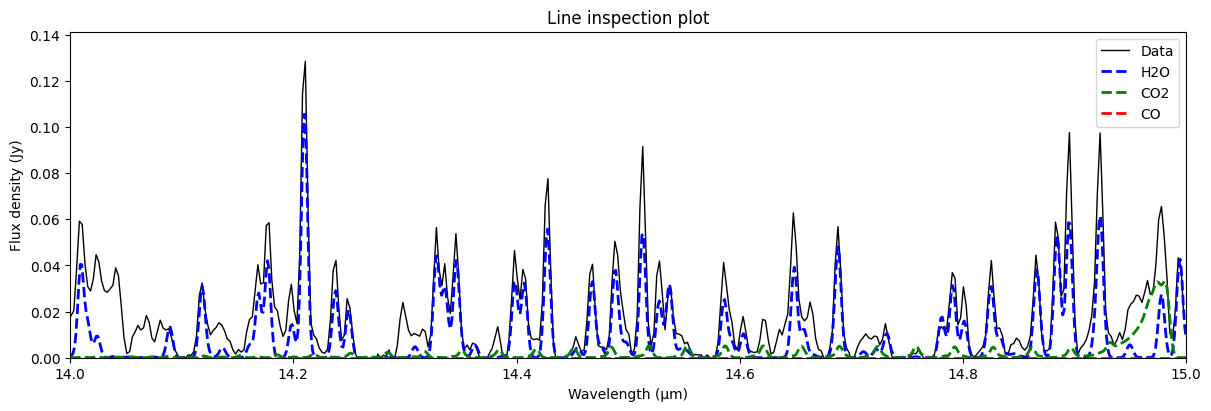

In [4]:
# --- LineInspectionPlot with ALL visible molecules ---

lip_all = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=15.0,
    molecules=mol_dict,       # pass the full MoleculeDict
    figsize=(12, 4),
)
lip_all.generate_plot()
lip_all.show()

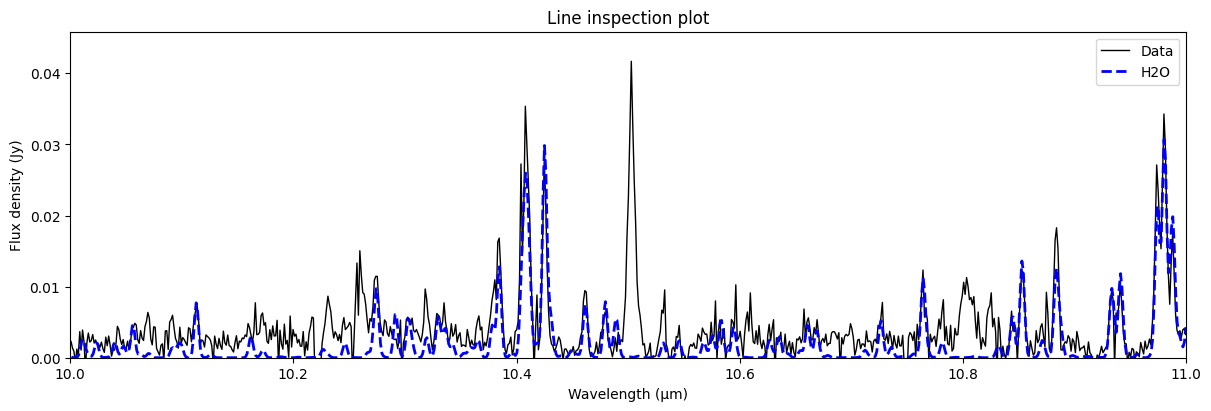

In [5]:
# --- Interactive range update with set_range() ---
# You can change the zoom window without creating a new object

lip.set_range(10.0, 11.0)   # shifts the view and regenerates automatically
display(lip.fig)           # use display() to re-render an already-shown figure in a notebook

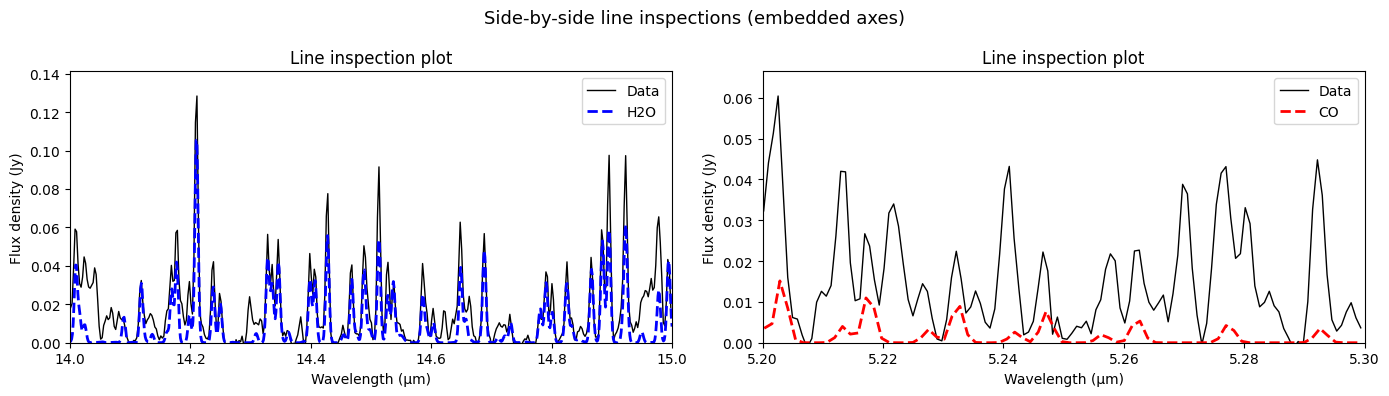

In [6]:
# --- Embed a LineInspectionPlot into a custom figure layout ---
# Pass an existing Axes object via the `ax` parameter

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left panel: H2O region
lip_h2o = LineInspectionPlot(
    wave_data=wave_grid, flux_data=observed_flux,
    xmin=14.0, xmax=15.0,
    molecule=mol_dict["H2O"],
    ax=axes[0],
)
lip_h2o.generate_plot()

# Right panel: CO region
lip_co = LineInspectionPlot(
    wave_data=wave_grid, flux_data=observed_flux,
    xmin=5.2, xmax=5.3,
    molecule=mol_dict["CO"],
    ax=axes[1],
)
lip_co.generate_plot()

fig.suptitle("Side-by-side line inspections (embedded axes)", fontsize=13)
fig.tight_layout()
plt.show()

### Line Information as a DataFrame

`LineInspectionPlot.get_line_info_dataframe()` converts a list of `(MoleculeLine, intensity, tau)` tuples into a tidy `pandas.DataFrame` — handy for filtering, sorting, or exporting line catalogues.

You can obtain the line tuples from any `Molecule` whose intensity has been calculated:

```python
line_data = molecule.intensity.get_lines_in_range_with_intensity(xmin, xmax)
df = LineInspectionPlot.get_line_info_dataframe(line_data)
```

In [7]:
# --- Get line information as a pandas DataFrame ---

# Ensure intensity is calculated for H2O
mol_dict["H2O"].calculate_intensity()

# Retrieve line tuples in a wavelength range
line_data = mol_dict["H2O"].intensity.get_lines_in_range_with_intensity(14.0, 17.0)
print(f"Found {len(line_data)} H2O lines between 14-17 μm\n")

# Build a DataFrame from the line data
df = LineInspectionPlot.get_line_info_dataframe(line_data)

df

Found 830 H2O lines between 14-17 μm



,wavelength_um,e_up_K,e_low_K,a_stein,g_up,g_low,upper_level,lower_level,intensity,tau
0,14.00137,5893.11475,4865.51709,0.000560,33,27,1_0_0|5_2_3,0_2_0|4_1_4,0.000223,0.000048
1,14.00355,3965.86646,2938.42896,0.013010,81,81,0_0_0|13_6_7,0_0_0|13_1_12,0.121423,0.026179
2,14.00537,6588.12744,5560.82373,0.068710,45,39,0_2_0|7_6_1,0_2_0|6_3_4,0.016420,0.003513
3,14.00969,3759.23560,2732.24878,0.958000,75,69,0_0_0|12_7_6,0_0_0|11_4_7,5.539603,2.277385
4,14.01395,7909.26562,6882.59131,0.037640,21,19,1_0_0|10_6_4,0_2_0|9_5_5,0.000888,0.000190
...,...,...,...,...,...,...,...,...,...,...
825,16.98433,6002.79590,5155.67627,80.710000,87,81,0_0_0|14_11_4,0_0_0|13_10_3,4.885032,20.613796
826,16.98433,6002.79590,5155.67627,80.690000,29,27,0_0_0|14_11_3,0_0_0|13_10_4,1.627940,6.869556
827,16.98466,4461.85156,3614.74756,0.000019,17,19,0_1_0|8_6_2,0_1_0|9_1_9,0.000017,0.000006
828,16.98688,3461.89990,2614.90649,0.000625,11,9,0_1_0|5_5_1,0_1_0|4_0_4,0.001192,0.000401


In [8]:
# You can now filter, sort, or export the DataFrame:
strong = df[df["intensity"] > df["intensity"].median()]
print(f"\n{len(strong)} lines above median intensity")

df_strong = strong[["wavelength_um", "e_up_K", "a_stein", "intensity"]]

df_strong


415 lines above median intensity


,wavelength_um,e_up_K,a_stein,intensity
1,14.00355,3965.86646,0.01301,0.121423
2,14.00537,6588.12744,0.06871,0.016420
3,14.00969,3759.23560,0.95800,5.539603
5,14.01574,2955.77783,0.28740,1.949726
7,14.02252,4500.29492,0.01578,0.078684
...,...,...,...,...
819,16.94520,8825.13184,2.60700,0.020558
821,16.97179,6868.78369,0.26830,0.072981
824,16.98230,8261.50977,2.51800,0.114072
825,16.98433,6002.79590,80.71000,4.885032


## 2. PopulationDiagramPlot — Boltzmann / Rotation Diagram

`PopulationDiagramPlot` plots $\ln\!\bigl(4\pi F / (h\nu\, A_u\, g_u)\bigr)$ vs upper-state energy $E_u$ using computed intensity data from a `Molecule`.

**Key parameters:**
- `molecule` — the `Molecule` object (intensity is computed automatically if needed)
- `highlight_lines` — optional list of `(MoleculeLine, intensity, tau)` to mark specific transitions
- `ax` — pre-existing Axes for embedding

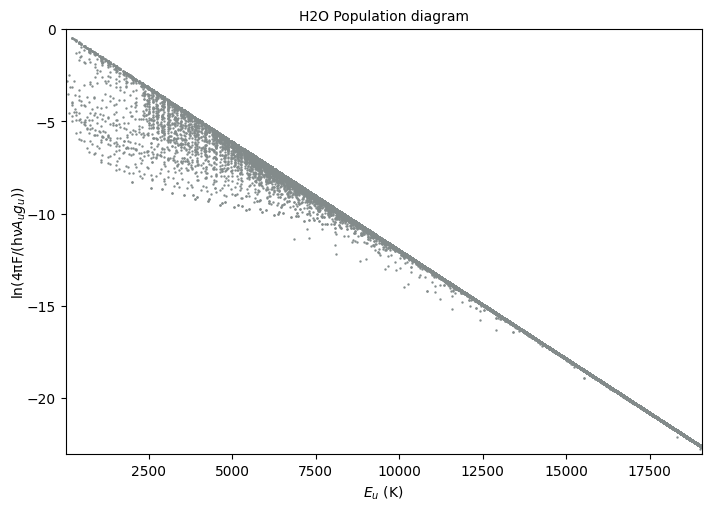

In [9]:
# --- Basic PopulationDiagramPlot ---

pdp = PopulationDiagramPlot(
    molecule=mol_dict["H2O"],
    figsize=(7, 5),
)
pdp.generate_plot()
pdp.show()

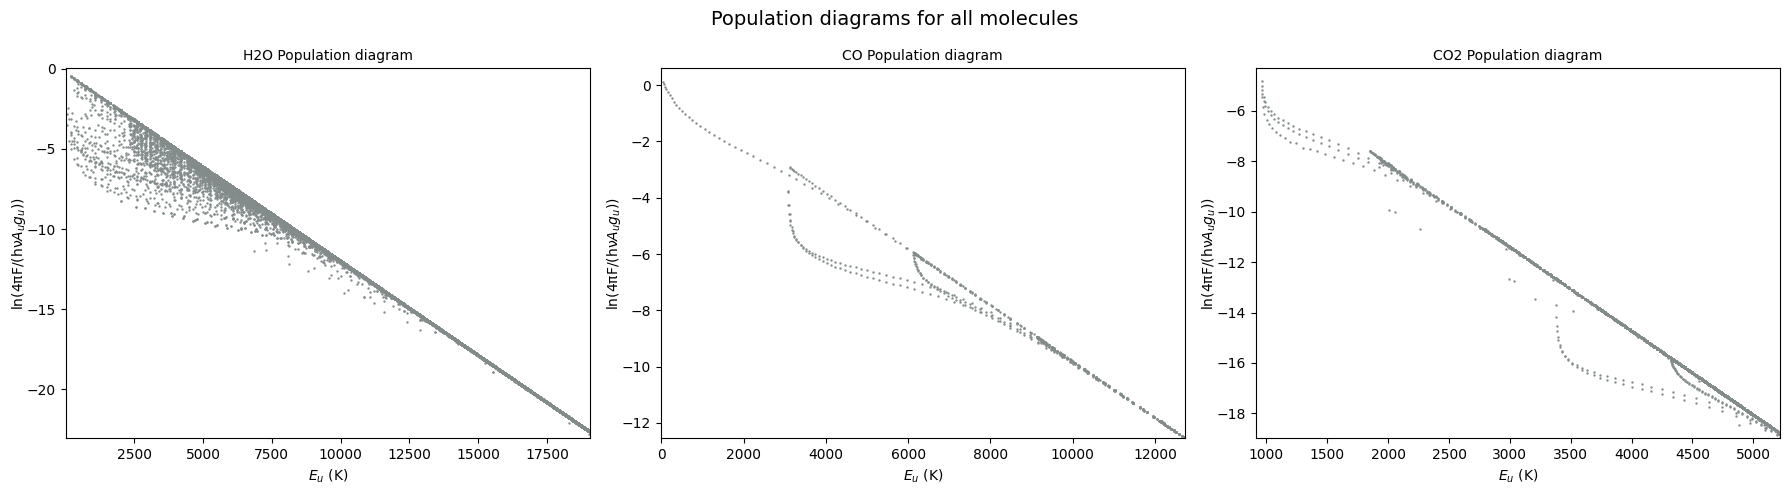

In [10]:
# --- Compare population diagrams for multiple molecules side-by-side ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, mol_name in zip(axes, ["H2O", "CO", "CO2"]):
    pdp = PopulationDiagramPlot(molecule=mol_dict[mol_name], ax=ax)
    pdp.generate_plot()

fig.suptitle("Population diagrams for all molecules", fontsize=14)
fig.tight_layout()
plt.show()

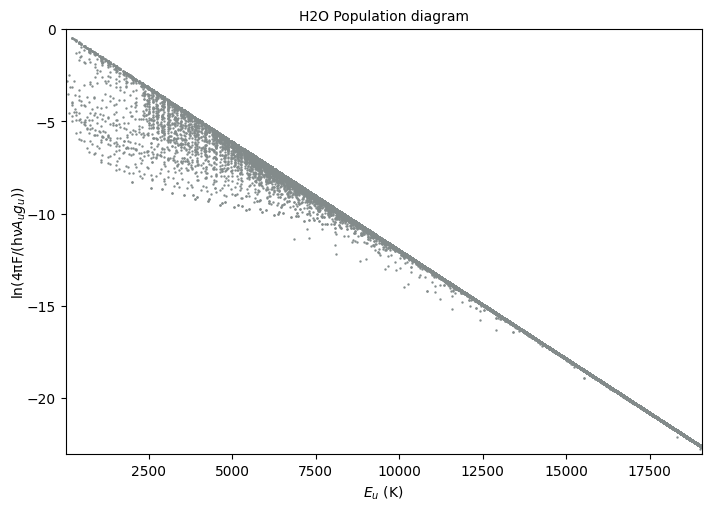

Switching to CO…


In [11]:
# --- Switch molecule in-place with set_molecule() ---
# Reuse the first PopulationDiagramPlot object from above

pdp_reuse = PopulationDiagramPlot(molecule=mol_dict["H2O"], figsize=(7, 5))
pdp_reuse.generate_plot()
pdp_reuse.show()

print("Switching to CO…")
pdp_reuse.set_molecule(mol_dict["CO"])    # regenerates automatically
pdp_reuse.show()

## 3. FullSpectrumPlot — Multi-Panel Overview

`FullSpectrumPlot` divides the full wavelength range into vertically stacked panels, each showing the observed data, molecule models, summed spectrum, and optional line/atomic annotations.

**Key parameters:**
- `wave_data`, `flux_data` — observed arrays
- `molecules` — `MoleculeDict` (visible molecules are plotted)
- `n_panels` / `step` — control the number of panels or the wavelength width per panel
- `xlim_range` — restrict to a sub-range of the data
- `line_list`, `atomic_lines` — DataFrames for annotation markers

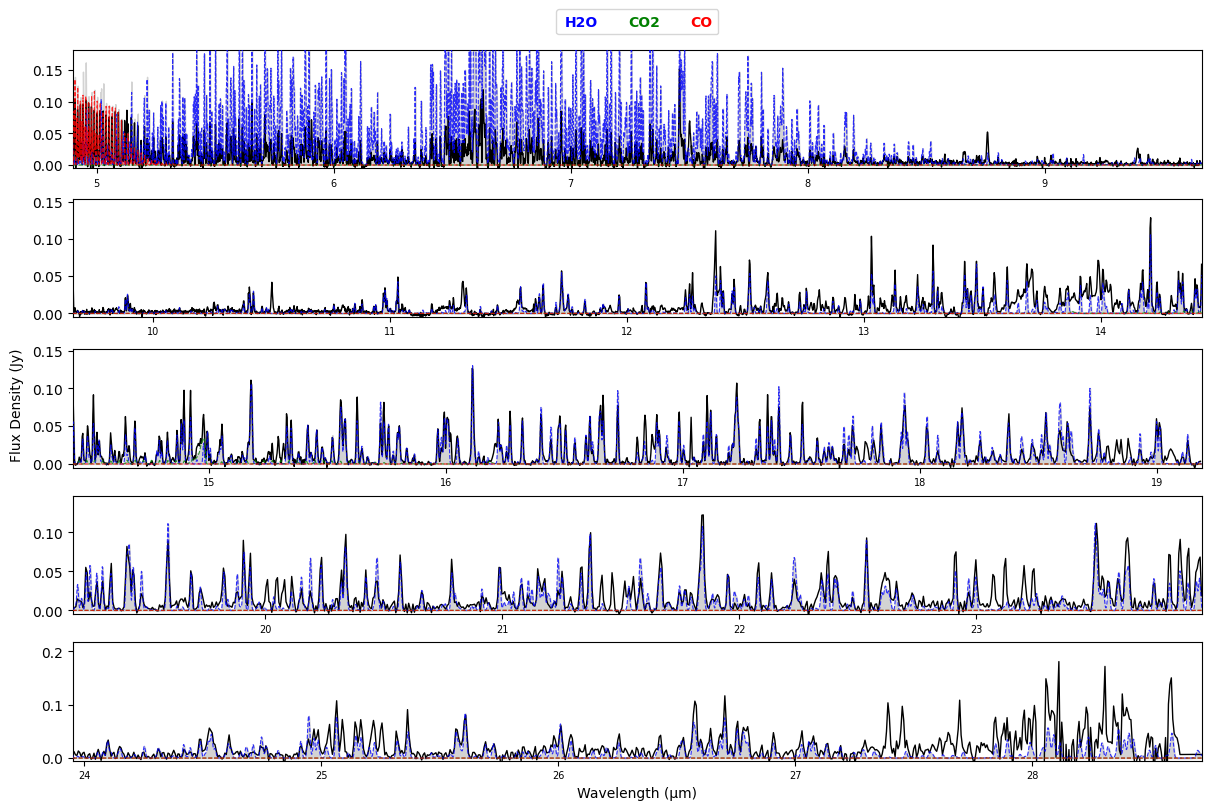

In [12]:
# --- Full spectrum overview with 5 panels ---

fsp = FullSpectrumPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    molecules=mol_dict,
    n_panels=5,
)
fsp.generate_plot()
fsp.show()

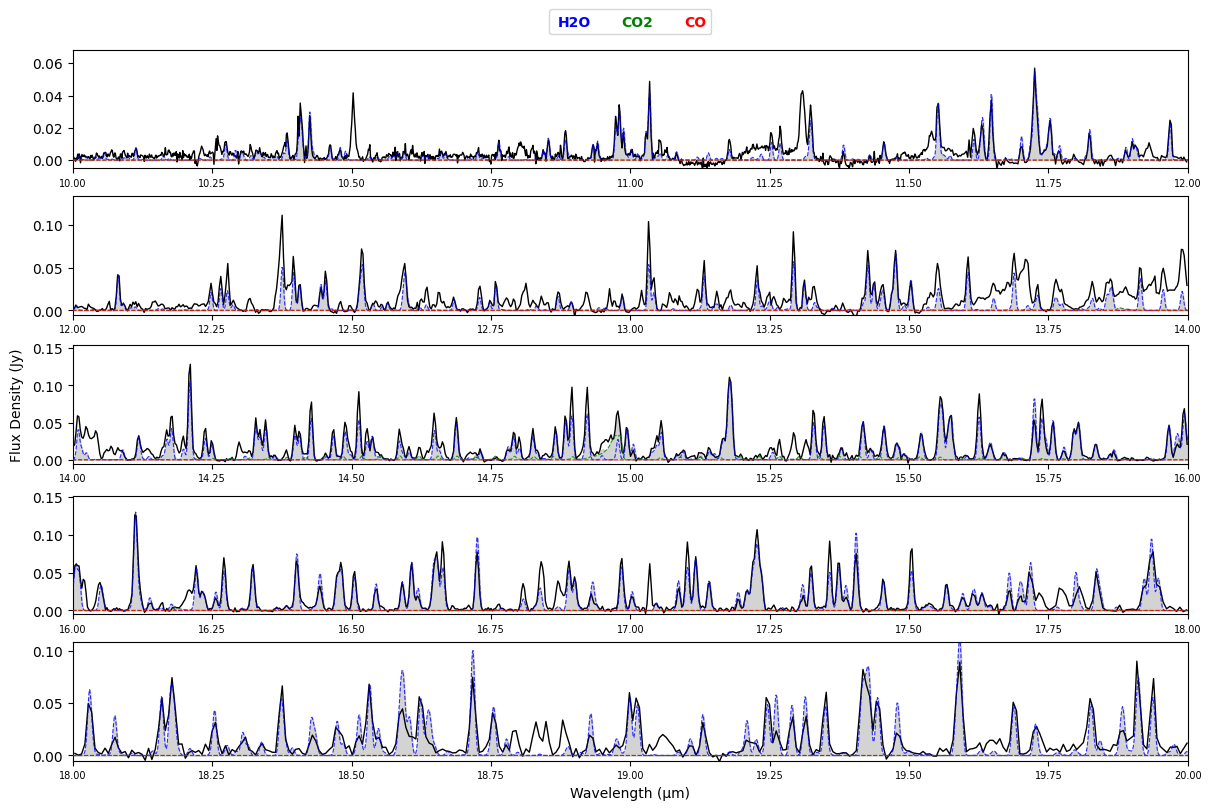

In [13]:
# --- Restrict to a sub-range and use a fixed step width ---

fsp_sub = FullSpectrumPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    molecules=mol_dict,
    xlim_range=(10.0, 20.0),   # only 10–20 μm
    step=2.0,                   # each panel spans 2 μm
)
fsp_sub.generate_plot()
fsp_sub.show()

## 4. MainPlotGrid — Three-Panel Composite

`MainPlotGrid` replicates the main GUI layout as a standalone figure:
- **Top row** — full spectrum with molecule overlays
- **Bottom-left** — line inspection (zoomed region)
- **Bottom-right** — population diagram

Internally it delegates to `LineInspectionPlot` and `PopulationDiagramPlot`, so you get the same rendering as the standalone classes.

**Key parameters:**
- `inspection_range` — `(xmin, xmax)` for the zoom panel (can also be set later via `set_inspection_range()`)
- `active_molecule` — molecule shown in the inspection and population panels
- `line_data` — line markers passed through to both bottom panels

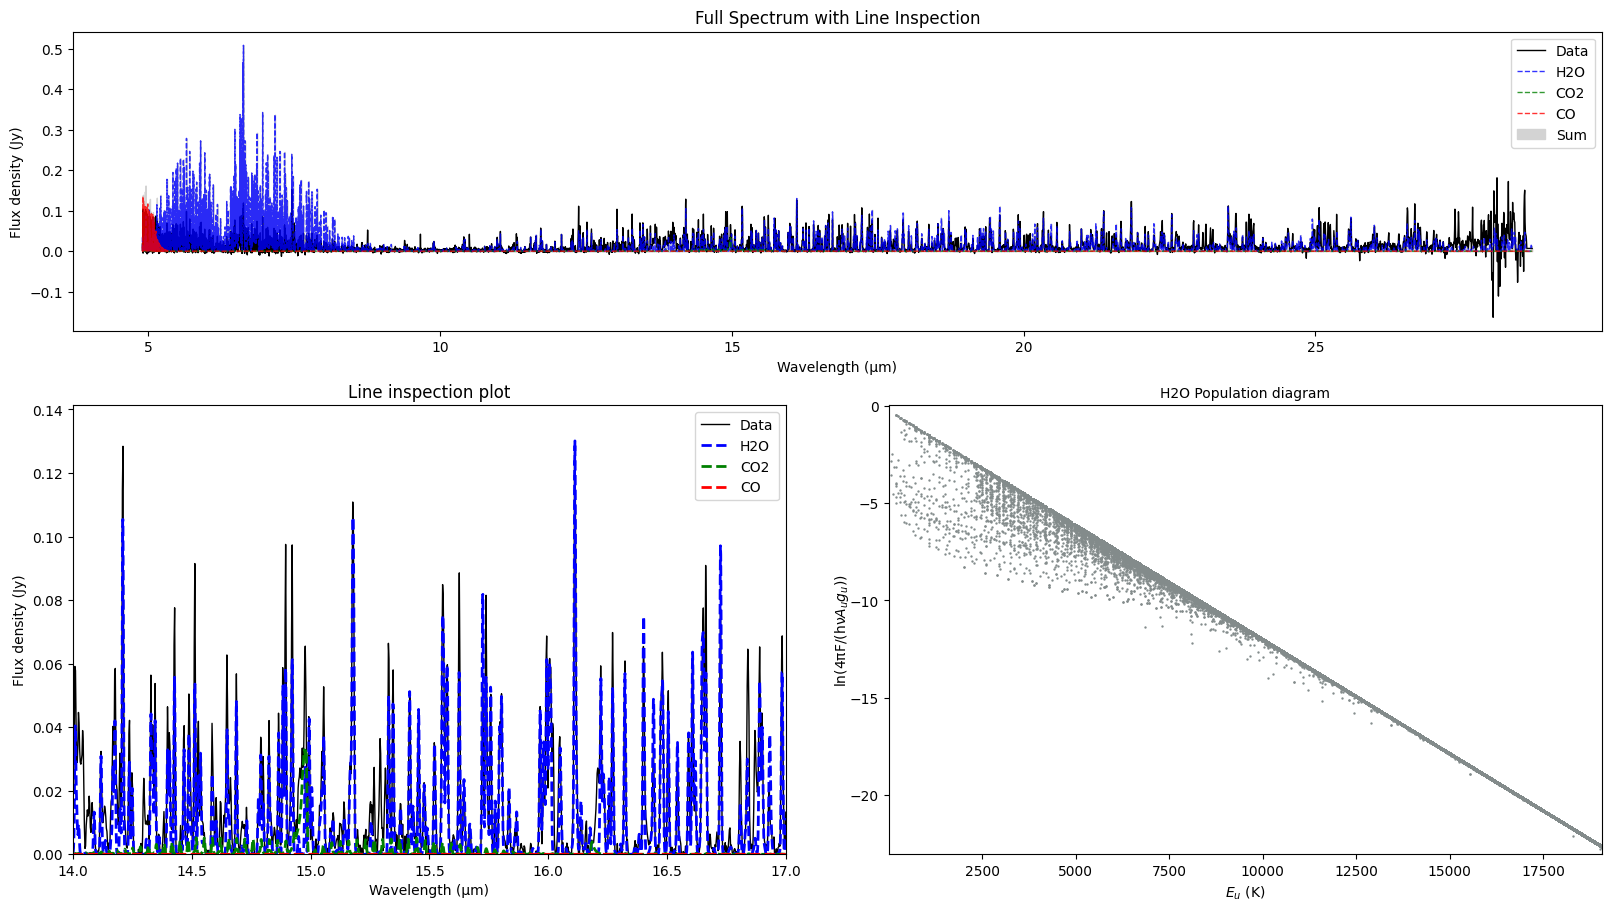

In [14]:
# --- Full three-panel grid ---

grid = MainPlotGrid(
    wave_data=wave_grid,
    flux_data=observed_flux,
    molecules=mol_dict,
    active_molecule=mol_dict["H2O"],
    inspection_range=(14.0, 17.0),
    figsize=(16, 9),
)
grid.generate_plot()
grid.show()

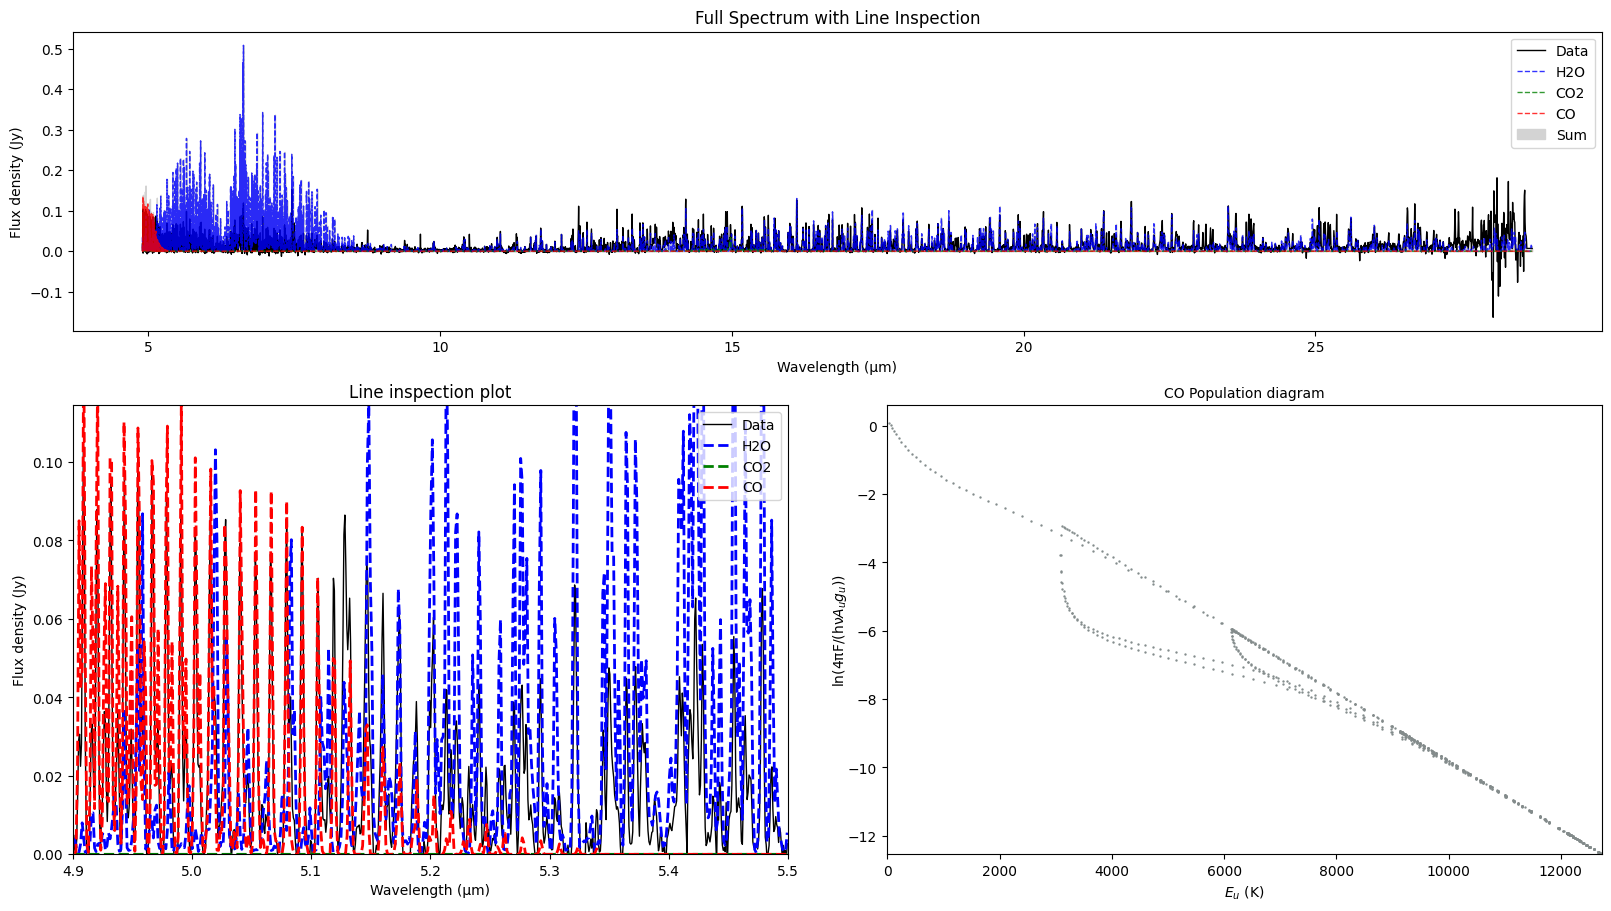

In [15]:
# --- Update the grid interactively ---

# Change the active molecule and inspection range without rebuilding
grid.set_active_molecule(mol_dict["CO"])
grid.set_inspection_range(4.9, 5.5)

# Re-render the updated figure (use display() for figures already shown in a previous cell)
display(grid.fig)

## 5. Theming & Customisation

All plot classes accept a `theme` dictionary that controls colours. The default is a light theme (`DEFAULT_THEME`). You can pass a custom theme for dark backgrounds, different scatter colours, etc.

Every plot class also supports `save(path, dpi=...)` and `close()` for exporting and memory management.

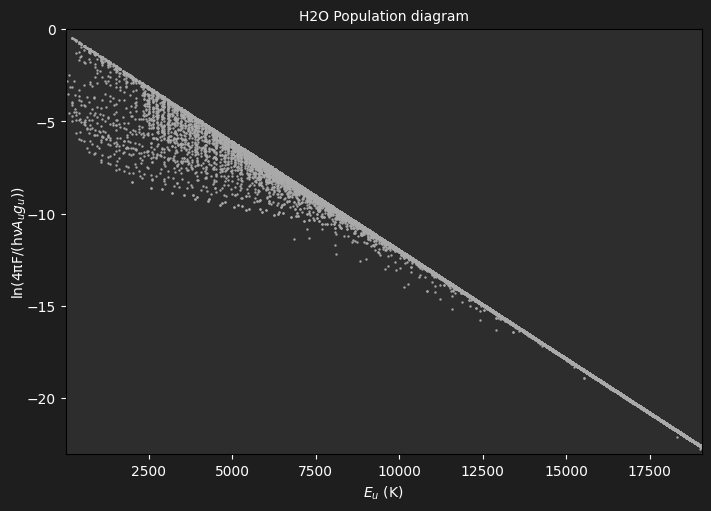

In [16]:
# --- Dark theme example ---

dark_theme = {
    "foreground": "white",
    "background": "#1e1e1e",
    "graph_fill_color": "#2d2d2d",
    "summed_spectra_color": "#555555",
    "scatter_main_color": "#aaaaaa",
    "active_scatter_line_color": "lime",
    "highlighted_line_color": "gold",
    "saved_line_color": "tomato",
    "default_molecule_color": "cyan",
    "zorder_observed": 2,
    "zorder_summed": 1,
    "zorder_model": 3,
}

# Population diagram with dark theme
pdp_dark = PopulationDiagramPlot(
    molecule=mol_dict["H2O"],
    theme=dark_theme,
    figsize=(7, 5),
)
pdp_dark.generate_plot()

# Set the figure and axes background to match the theme
pdp_dark.fig.set_facecolor(dark_theme["background"])
pdp_dark.ax.set_facecolor(dark_theme["graph_fill_color"])
pdp_dark.ax.tick_params(colors=dark_theme["foreground"])
pdp_dark.show()

In [17]:
# --- Saving a figure ---
# All plot classes support .save() which returns the output Path

import os

lip_save = LineInspectionPlot(
    wave_data=wave_grid, flux_data=observed_flux,
    xmin=14.0, xmax=17.0,
    molecule=mol_dict["H2O"],
    figsize=(10, 4),
)
lip_save.generate_plot()

# Save to the current working directory (save to any path that you want)
save_path = Path.cwd() / "line_inspection_demo.png"
saved = lip_save.save(save_path, dpi=150)
print(f"Output Saved! ({os.path.getsize(saved) / 1024:.0f} KB)")

# Clean up
lip_save.close()
print("Figure closed — memory freed.")

Output Saved! (165 KB)
Figure closed — memory freed.


## 6. BasePlot Utility Methods

All plot classes inherit static helper methods from `BasePlot` that you can use directly:

| Method | Description |
|--------|-------------|
| `BasePlot.get_molecule_display_name(mol)` | User-facing label (`displaylabel` or `name`) |
| `BasePlot.get_molecule_color(mol)` | Colour string assigned to the molecule |
| `BasePlot.get_molecule_spectrum_data(mol, wave)` | Returns `(wavelength, flux)` arrays |
| `BasePlot.get_intensity_data(mol)` | Returns the intensity DataFrame (triggers calculation if needed) |

In [18]:
# --- Using BasePlot static helpers directly ---

for mol_name, mol in mol_dict.items():
    label = BasePlot.get_molecule_display_name(mol)
    color = BasePlot.get_molecule_color(mol)
    wave, flux = BasePlot.get_molecule_spectrum_data(mol, wave_grid)
    intensity_df = BasePlot.get_intensity_data(mol)

    n_lines = len(intensity_df) if intensity_df is not None else 0
    peak = f"{np.nanmax(flux):.2e}" if flux is not None else "N/A"

    print(f"{label:6s}  color={color:8s}  peak_flux={peak}  intensity_lines={n_lines}")

H2O     color=#0000FF   peak_flux=5.08e-01  intensity_lines=305561
CO      color=#FF0000   peak_flux=1.35e-01  intensity_lines=1334
CO2     color=green     peak_flux=3.31e-02  intensity_lines=173129


## 7. Quick Reference

### Plot Classes

| Class | Purpose | Key Methods |
|-------|---------|-------------|
| `LineInspectionPlot` | Zoomed wavelength region with molecule overlay | `generate_plot()`, `set_range(xmin, xmax)` |
| `PopulationDiagramPlot` | Boltzmann / rotation diagram | `generate_plot()`, `set_molecule(mol)` |
| `FullSpectrumPlot` | Multi-panel full spectrum overview | `generate_plot()`, `set_line_list(df)`, `set_atomic_lines(df)` |
| `MainPlotGrid` | 3-panel composite (spectrum + inspection + pop-diagram) | `generate_plot()`, `set_inspection_range()`, `set_active_molecule()`, `refresh()` |

### Common API (inherited from `BasePlot`)

| Method | Description |
|--------|-------------|
| `generate_plot()` | Build or refresh the plot |
| `show(block=False)` | Display interactively |
| `save(path, dpi=...)` | Export to PNG / PDF / SVG |
| `close()` | Free figure memory |
| `get_figure()` | Access the underlying `matplotlib.Figure` |

### Embedding in Custom Layouts

Pass an `ax=` parameter (existing `matplotlib.Axes`) to any plot class to render into a pre-existing figure layout instead of creating a new figure.

### Import Path

```python
from iSLAT.Modules.Plotting import (
    LineInspectionPlot,
    PopulationDiagramPlot,
    FullSpectrumPlot,
    MainPlotGrid,
    BasePlot,
    DEFAULT_THEME,
)
```